In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")


seed = 2025

In [ ]:
# Load preprocessed data
train_df = pd.read_csv('train_preprocessed.csv')
test_df = pd.read_csv('test_preprocessed.csv')

3063

### Data Preparation

In [ ]:
# Separate features and target
exclude_cols = ['id', 'player_id', 'spending_30d']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X = train_df[feature_cols]
X_test = test_df[feature_cols]
y_original = train_df['spending_30d']

# Stage 1: Binary target (will spend or not)
y_binary = (y_original > 0).astype(int)

# Stage 2: Regression target (amount) - only for spenders
mask_spenders = y_original > 0
print(f"selected spenders data: {mask_spenders.mean()*100:.2f}%")
X_spenders = X[mask_spenders]
y_amount = y_original[mask_spenders]

selected spenders data: 51.80%


### Modeling

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    loss_function='Tweedie:variance_power=1.5',
    verbose=0,
    random_seed=seed,
)

In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
kf_reg = KFold(n_splits=5, shuffle=True, random_state=seed)

In [31]:
mae_scores = -cross_val_score(model, X, y_original, cv=kf_reg, scoring='neg_mean_absolute_error', n_jobs=-1)

mean_y = y_original.mean()
nmae_scores = 1 / (1 + mae_scores / mean_y)

mae = mae_scores.mean()
nmae = nmae_scores.mean()

print(f"MAE: {mae:.4f}")
print(f"NMAE: {nmae:.4f}")

MAE: 2911.9839
NMAE: 0.7808


### Hyperparameter tuning

In [ ]:
import optuna
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

CONST_MEAN_Y = y_original.mean()
print(f"Global Mean Y (Spenders) used for NMAE: {CONST_MEAN_Y:.4f}")

def objective(trial):
    # --- 1. Define Hyperparameters for CatBoost ---
    
    # CatBoost กำหนด Tweedie Variance Power ในรูปแบบ String เช่น 'Tweedie:variance_power=1.5'
    tweedie_variance_power = trial.suggest_float('tweedie_variance_power', 1.05, 1.95)
    
    params = {
        # Objective & Metric
        'loss_function': f'Tweedie:variance_power={tweedie_variance_power}',
        'eval_metric': 'MAE', # ใช้ Monitor ตอน Train
        
        # Boosting params
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        
        # Tree Structure (CatBoost ใช้ Symmetric trees, depth สำคัญมาก)
        'depth': trial.suggest_int('depth', 4, 10), # CatBoost ปกติไม่ควรเกิน 10 เพราะจะช้ามาก
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        
        # Regularization & Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # ต้องใช้คู่กับ bootstrap_type='Bernoulli' หรือ 'MVS'
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0), # คล้าย colsample_bytree
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), # แทน reg_lambda
        
        # Misc
        'random_seed': seed,
        'verbose': False, # ปิด Log
        'allow_writing_files': False, # ปิดการสร้าง folder catboost_info
        'bootstrap_type': 'MVS', # แนะนำ MVS หรือ Bernoulli สำหรับ subsample
        
        # 'task_type': 'GPU', # เปิดถ้ามี GPU (จะเร็วขึ้นมาก)
    }

    # --- 2. Cross-Validation ---
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    mae_scores = []
    
    X_values = X.values
    y_values = y_original.values

    for train_idx, val_idx in kf.split(X_values, y_values):
        X_train, X_val = X_values[train_idx], X_values[val_idx]
        y_train, y_val = y_values[train_idx], y_values[val_idx]

        # Init Model
        model = CatBoostRegressor(**params)
        
        # Fit with Early Stopping
        # CatBoost ใช้ early_stopping_rounds ใน fit() ได้เลย และ use_best_model=True เป็น Default ถ้ามี eval_set
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=100,
            verbose=False # ปิด log แต่ละ fold เพื่อความสะอาด
        )
        
        # Predict
        preds = model.predict(X_val)
        preds = np.maximum(preds, 0) # Clip ค่าลบ
        
        # Calculate MAE for this fold
        fold_mae = mean_absolute_error(y_val, preds)
        mae_scores.append(fold_mae)

    # --- 3. Calculate NMAE Score ---
    avg_mae = np.mean(mae_scores)
    
    # สูตร NMAE: 1 / (1 + MAE / Mean_Y)
    nmae_score = 1 / (1 + (avg_mae / CONST_MEAN_Y))

    return nmae_score

# --- 4. Optimization ---
study = optuna.create_study(direction='maximize')
print("Start Optimization (CatBoost)...")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*30)
print(f"Best NMAE: {study.best_value:.5f}")
print("Best Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2025-11-20 18:08:41,904] A new study created in memory with name: no-name-6d3b9ca0-6ebf-43c3-ad62-e035060deded


Global Mean Y (Spenders) used for NMAE: 10369.5784
Start Optimization (CatBoost)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-20 18:13:09,861] Trial 0 finished with value: 0.5130439852139863 and parameters: {'tweedie_variance_power': 1.641541819424429, 'iterations': 2570, 'learning_rate': 0.0021142091866205334, 'depth': 10, 'min_data_in_leaf': 89, 'subsample': 0.6033388632002061, 'colsample_bylevel': 0.8686373417854365, 'l2_leaf_reg': 1.0608911111733839e-07}. Best is trial 0 with value: 0.5130439852139863.
[I 2025-11-20 18:15:29,682] Trial 1 finished with value: 0.7731442254467887 and parameters: {'tweedie_variance_power': 1.6434933359090198, 'iterations': 1817, 'learning_rate': 0.019958879280792235, 'depth': 9, 'min_data_in_leaf': 100, 'subsample': 0.9583104778922449, 'colsample_bylevel': 0.633518307813759, 'l2_leaf_reg': 1.2738594180121443}. Best is trial 1 with value: 0.7731442254467887.
[I 2025-11-20 18:16:34,736] Trial 2 finished with value: 0.7775224739943639 and parameters: {'tweedie_variance_power': 1.9384110855100738, 'iterations': 4240, 'learning_rate': 0.009387382455724508, 'depth': 4, '

In [190]:
best_params = study.best_params
best_params['loss_function'] = f'Tweedie:variance_power={best_params["tweedie_variance_power"]}'

In [191]:
best_params.pop('tweedie_variance_power')

1.5403945757253048

In [ ]:
final_model = CatBoostRegressor(**best_params)
final_model.fit(X, y_original)

# Predict Test Set
final_preds = final_model.predict(X_test)
final_preds = np.maximum(final_preds, 0)

0:	learn: 19071.7624078	total: 8.27ms	remaining: 33.7s
1:	learn: 18953.1885566	total: 15.7ms	remaining: 32.1s
2:	learn: 18835.3524467	total: 23.4ms	remaining: 31.8s
3:	learn: 18718.2494868	total: 31.6ms	remaining: 32.2s
4:	learn: 18601.8751111	total: 39.3ms	remaining: 32s
5:	learn: 18486.2248121	total: 47ms	remaining: 31.9s
6:	learn: 18371.2940689	total: 54.4ms	remaining: 31.6s
7:	learn: 18257.0784111	total: 62.3ms	remaining: 31.7s
8:	learn: 18143.5733795	total: 69.7ms	remaining: 31.5s
9:	learn: 18030.7745849	total: 76.9ms	remaining: 31.3s
10:	learn: 17918.6776161	total: 84.1ms	remaining: 31.1s
11:	learn: 17807.2781143	total: 91.1ms	remaining: 30.8s
12:	learn: 17696.5717369	total: 98.8ms	remaining: 30.9s
13:	learn: 17586.5541906	total: 105ms	remaining: 30.6s
14:	learn: 17477.2211793	total: 113ms	remaining: 30.6s
15:	learn: 17368.5683878	total: 120ms	remaining: 30.4s
16:	learn: 17260.5917092	total: 128ms	remaining: 30.5s
17:	learn: 17153.2868773	total: 135ms	remaining: 30.4s
18:	learn: 

In [193]:
final_preds

array([   496.05689114,    904.88702774, 148248.26642876, ...,
         7400.95658611,    407.54783228,   1245.11163226])

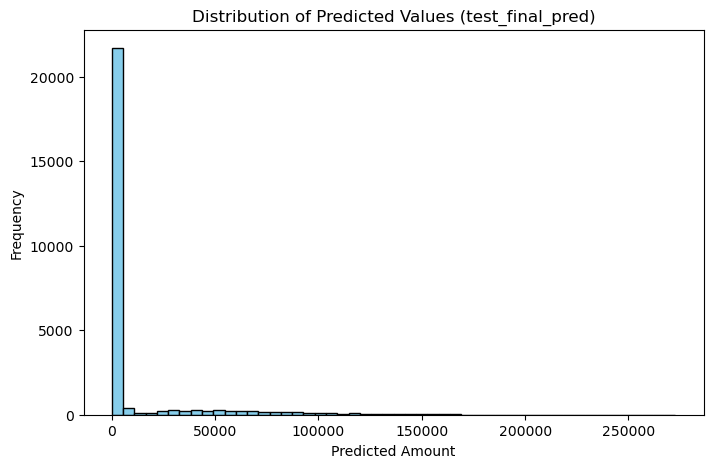

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(final_preds, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Values (test_final_pred)')
plt.xlabel('Predicted Amount')
plt.ylabel('Frequency')
plt.show()

### Submission

In [195]:
best_csv = pd.read_csv("ThreeTreeStackEnsembleHyperparameter0.2-VVS_XGBV1-twoStageSimple-ConvNextxxl_aug-isoXsvm.csv")

In [196]:
best_csv['task3'] = final_preds

In [197]:
best_csv.to_csv("ThreeTreeStackEnsembleHyperparameter0.2-VVS_XGBV1-TweedieCATB_optuna_featEn-ConvNextxxl_aug-isoXsvm.csv", index=False)